# Algoritmo de Grover - Implementación en qiskit

Tenemos una función $f : \{0, 1\}^n \rightarrow \{0, 1\}$ con $|f^{-1}(1)| = M$.  
El problema que queremos resolver es, dado un oráculo $O_f$ que ``codifica'' la función $f$ en un operador cuántico tal que  
$O_f\ket{i} = (-1)^{f(i)}\ket{i}$, encontrar el valor de $x$.

Comenzamos el algoritmo con el estado:


$$\ket{\psi_0} = H^{\otimes n}\ket{0}^{\otimes n} = \frac{1}{2^{n/2}} \sum_{i \in \{0, 1\}^n} \ket{i}$$


Notemos que, si medimos el estado $\ket{\psi_0}$ en la base computacional, obtendremos una distribución uniforme, donde la probabilidad de medir cualquier $i \in \{0, 1\}^n$ es constante e igual a $1/2^n$.

El algoritmo de Grover consiste en aplicar $R$ veces el operador de Grover $G = A O_f$, donde $A = 2\ket{+}^{\otimes n}\bra{+}^{\otimes n} - \mathbb{I}$. Si conocemos $M$, entonces el valor óptimo de $R$ es:

$$
R = \text{C.I.}\left( 
\frac{\arccos\!\left(\frac{\sqrt{M}}{\sqrt{N}}\right)}
{2\,\arcsin\!\left(\frac{\sqrt{M}}{\sqrt{N}}\right)} 
\right)
\hspace{5pt}
\text{donde } \text{C.I.}(x) \text{ refiere al entero más cercano a } x, 
\text{ tomando } \text{C.I.}(n+0.5) = n.
$$



## Implementación del operador de difusión:

El operador $A$ de difusión se puede implementar fácilmente notando que:

$$
\begin{split}
A & = 2\ket{+}^{\otimes n}\bra{+}^{\otimes n} - \mathbb{I} \\
  & = H^{\otimes n} \left( 2\ket{0}^{\otimes n}\bra{0}^{\otimes n} - \mathbb{I} \right) H^{\otimes n}
\end{split}
$$

Ahora, notemos que el operador $\mathbb{I} - 2\ket{0}^{\otimes n}\bra{0}^{\otimes n}$ deja a todos los estados de la base computacional igual, excepto al $\ket{0}$, al cual le cambia el signo. Esto se puede implementar con una compuerta $Z$ controlada en todos los qubits (que solo cambia de signo a $\ket{2^{n} - 1}$), aplicando una $X$ antes y después de la $Z$ controlada.


In [51]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import StatevectorSampler
from qiskit.circuit.library import ZGate, XGate
from qiskit.visualization import plot_histogram

## Ejemplo 1: 

Vamos a aplicar Grover para una función que marca al elemento $x =  1111$. Notemos que en este caso:

- $M = 1$
- $N = 2^4 = 16$
- $R = 3$

In [52]:
def oracle1(qc, qr, qubits_list = None):
    '''
    Append the Grover oracle for a function f that marks 11...1 to a quantum circuit qc.
    This oracle uses phase kickback: it implements |x>|y> ---> |x>|y + f(x)>.
    The |y> qubit is the last qubit of the register qr.

    Args:
        - qc (QuantumCircuit): Qiskit Quantum Circuit
        - qr (QuantumRegister): Qiskit Quantum Register in which to apply the oracle
        - qubits_list (int[]): list indicating the order of the qubits. If None, the natural order is used (from zero to the number of qubits in qr).

    Returns:
        - None
    '''

    if (qubits_list == None):
        qubits_list = [i for i in range(len(qr))]

    n = len(qubits_list)
    qc.append(XGate().control(n-1), qubits_list)


def grover(qc, qr, oracle_f, ancilla = None, iterations = None, qubits_list = None):
    '''
    Append the Grover algorithm circuit to a quantum circuit qc. Assuming that all qubits start at |0>

    Args:        
        - qc (QuantumCircuit): Qiskit Quantum Circuit
        - qr (QuantumRegister): Qiskit Quantum Register in which to apply the Grover operator
        - oracle_f: Function that appends the oracle to the circuit. Receives a QuantumCircuit, a QuantumRegister, and a qubits_list
        - ancilla (QuantumRegister): Quantum Register for the ancilla qubits. Might be more than just one qubit if the oracle needs extra auxiliary qubits
        - iterations (int): Number of iterations to apply. If None, apply one iteration
        - qubits_list (int[]): list indicating the order of the qubits. If None, the natural order is used (from zero to the number of qubits in qr)

    Returns: 
        - None
    '''

    if not iterations:
        iterations = 1

    if (qubits_list == None):
        qubits_list = [i for i in range(len(qr))]

    n = len(qubits_list)

    # Initial state of the ancilla qubit
    if ancilla:
        qc.x(ancilla[-1])
        qc.h(ancilla[-1])

    # Initial state of the principal register
    qc.h(qubits_list)
    
    for _ in range(iterations):
        qc.barrier()
        # Append oracle O_f. If ancilla != None, append ancillas to the register for the oracle function
        if ancilla:
            oracle_f(qc, qubits_list + [anc for anc in ancilla])
        else:
            oracle_f(qc, qubits_list)
        qc.barrier()

        # Append diffusion operator to the principal qubits
        qc.h(qubits_list)
        qc.x(qubits_list)
        qc.append(ZGate().control(n - 1), qubits_list)
        qc.x(qubits_list)
        qc.h(qubits_list)

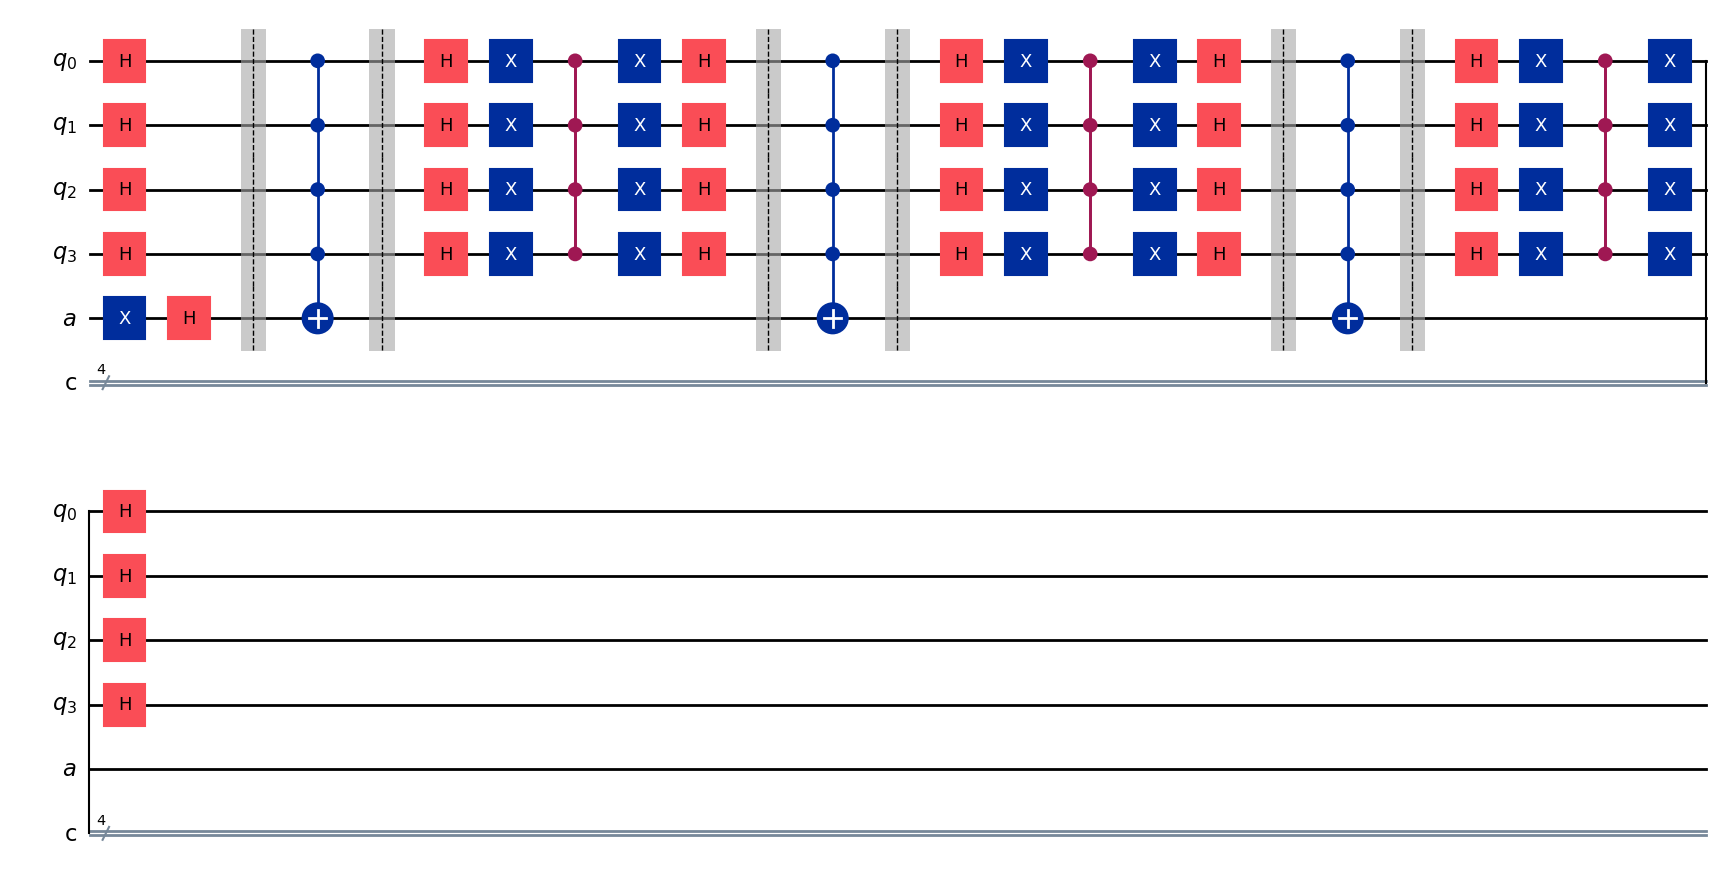

In [53]:
# Generate a circuit with three iterations of Grover
qubit_count = 4
qr = QuantumRegister(qubit_count, 'q')
cr = ClassicalRegister(qubit_count, 'c')
ancilla = QuantumRegister(1, 'a')
qc = QuantumCircuit(qr, ancilla, cr)

grover(qc, qr, oracle1, ancilla=ancilla, iterations=3)

qc.draw("mpl")

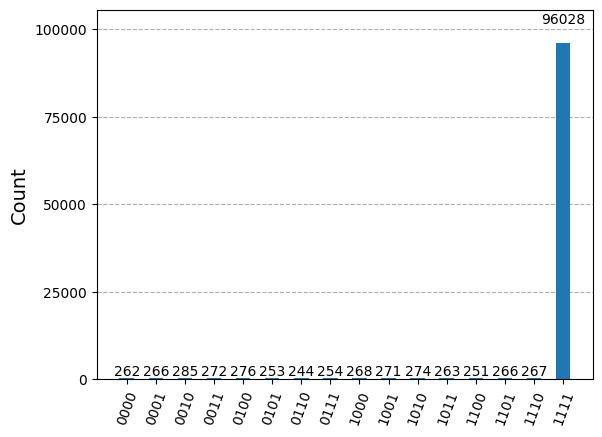

In [54]:
# Simulate the circuit with 100,000 shots
qc.measure(qr, cr)

sampler = StatevectorSampler()
shots = 100000

job = sampler.run([qc], shots=shots)

# Extract the result for the 0th pub (this example only has one pub)
result = job.result()[0]
counts = result.data.c.get_counts()

plot_histogram(counts)

## Ejemplo 2: 

Vamos a aplicar Grover para una función que marca a los elementos $x_1 =  1111$ y $x_2 = 0111$. Notemos que en este caso:

- $M = 2$
- $N = 2^4 = 16$
- $R = 2$

In [57]:
def oracle2(qc, qr, qubits_list = None):
    '''
    Append the Grover oracle for a function f that marks 11...1 and 01...1 to a quantum circuit qc.
    This oracle uses phase kickback: it implements |x>|y> ---> |x>|y + f(x)>.
    The |y> qubit is the last qubit of the register qr.

    Args:
        - qc (QuantumCircuit): Qiskit Quantum Circuit
        - qr (QuantumRegister): Qiskit Quantum Register in which to apply the oracle
        - qubits_list (int[]): list indicating the order of the qubits. If None, the natural order is used (from zero to the number of qubits in qr).

    Returns:
        - None
    '''

    if (qubits_list == None):
        qubits_list = [i for i in range(len(qr))]

    n = len(qubits_list)
    qc.append(XGate().control(n-2), qubits_list[0:n-2] + [qubits_list[-1]])

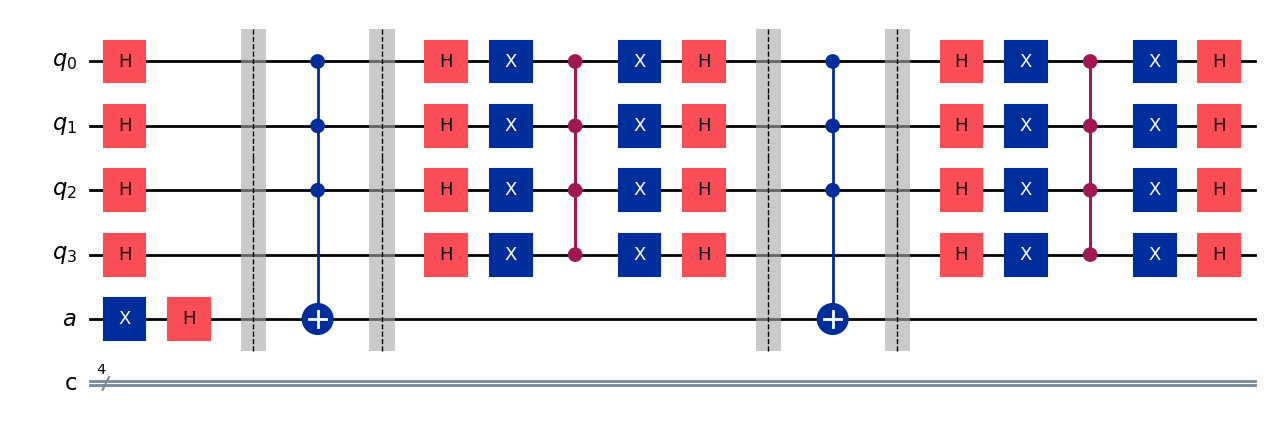

In [61]:
# Generate a circuit with three iterations of Grover
qubit_count = 4
qr = QuantumRegister(qubit_count, 'q')
cr = ClassicalRegister(qubit_count, 'c')
ancilla = QuantumRegister(1, 'a')
qc = QuantumCircuit(qr, ancilla, cr)

grover(qc, qr, oracle2, ancilla=ancilla, iterations=2)

qc.draw("mpl")

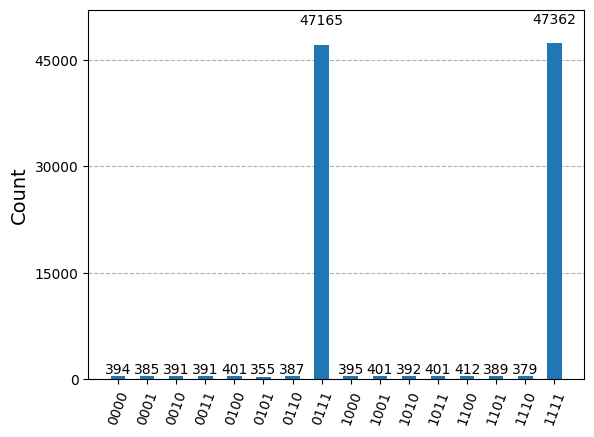

In [62]:
# Simulate the circuit with 100,000 shots
qc.measure(qr, cr)

sampler = StatevectorSampler()
shots = 100000

job = sampler.run([qc], shots=shots)

# Extract the result for the 0th pub (this example only has one pub)
result = job.result()[0]
counts = result.data.c.get_counts()

plot_histogram(counts)

## Ejemplo 3: 

Funcón que marca a $M > N/2$ elementos. Tomamos $f$ que marque todos los elementos que tengan el primer qubit en $1$ (secuencias de la forma $x_4x_3x_21$) y además a los elementos $0000$, $1110$.

- $M = 10$
- $N = 2^4 = 16$
- $\theta = 2\arcsin(\sqrt{M}/\sqrt{N}) = 1.83 \approx 104°$

Usamos 3 ancillas para implementar: $\ket{x}\ket{000}\ket{y} \rightarrow \ket{x}\ket{000}\ket{y \oplus f(x)}$

In [63]:
def oracle2(qc, qr, qubits_list = None):
    '''
    Append the Grover oracle for a function f that marks the states with:
        (1) x1 = 1
        (2) 00...00
        (3) 11...10
    This oracle uses phase-kickback: it implements |x>|y> ---> |x>|y + f(x)>.
    The |y> qubit is the last qubit of the register qr. The oracle uses three extra ancillas 
    to store each of the conditions (1), (2), and (3).

    Args:
        - qc (QuantumCircuit): Qiskit Quantum Circuit
        - qr (QuantumRegister): Qiskit Quantum Register in which to apply the oracle
        - qubits_list (int[]): List indicating the order of the qubits. If None, the natural order is used (from zero to the number of qubits in qr).

    Returns:
        - None
    '''


    if (qubits_list == None):
        qubits_list = [i for i in range(len(qr))]

    n = len(qubits_list)
    # CNOT with the first qubit and the first of three ancillas: mark states with x1 = 1 in the first ancilla
    qc.append(XGate().control(1), [qubits_list[0]] + [qubits_list[-4]])

    # Multicontrolled NOT with NOT X1 and X2, X3, ..., Xn in the second ancilla: mark states with x1 = 0, x2 = x3 = ... = 1 in the second ancilla
    qc.x(qubits_list[0])
    qc.append(XGate().control(n-4), qubits_list[0:n-4] + [qubits_list[-3]])

    # Multicontrolled NOT with NOT X1, NOT X2, NOT X3, ... NOT Xn in the third ancilla: mark states with x1 = 0, x2 = x3 = ... = 0 in the third ancilla
    qc.x(qubits_list[1:n-4])
    qc.append(XGate().control(n-4), qubits_list[0:n-4] + [qubits_list[-2]])

    # Return principal qubits to their original state
    qc.x(qubits_list[0:n-4])

    # OR between the three first ancillas on the ancilla qubit used for phase-kickback
    qc.x(qubits_list[::-1][0:4])
    qc.append(XGate().control(3), qubits_list[::-1][1:4] + [qubits_list[-1]])
    qc.x(qubits_list[::-1][1:4])

    # Inverse of the first part of the oracle to reset the first three ancillas to the state |0>
    qc.x(qubits_list[0:n-4])
    qc.append(XGate().control(n-4), qubits_list[0:n-4] + [qubits_list[-2]])
    qc.x(qubits_list[1:n-4])
    qc.append(XGate().control(n-4), qubits_list[0:n-4] + [qubits_list[-3]])
    qc.x(qubits_list[0])
    qc.append(XGate().control(1), [qubits_list[0]] + [qubits_list[-4]])

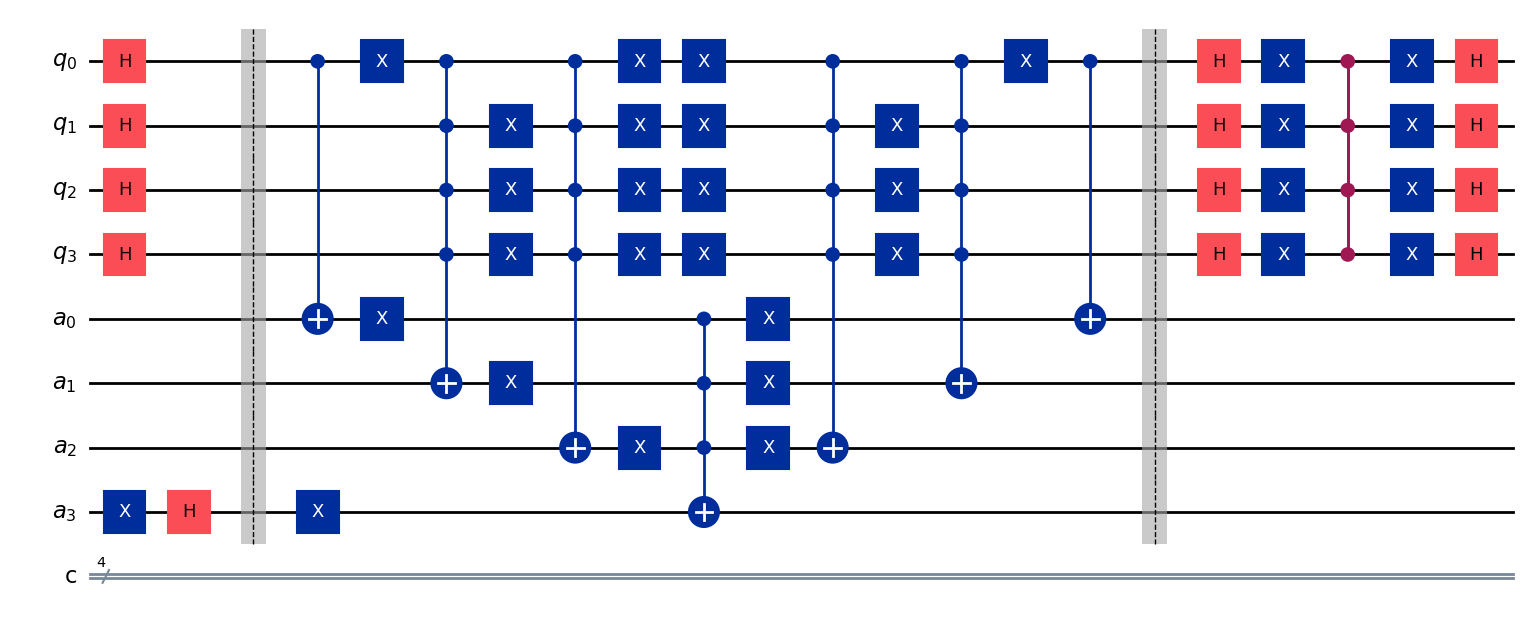

In [64]:
# Generate circuits with 1 and 2 Grover iterations
qubit_count = 4
qr = QuantumRegister(qubit_count, 'q')
cr = ClassicalRegister(qubit_count, 'c')
ancilla = QuantumRegister(4, 'a')
qc1 = QuantumCircuit(qr, ancilla, cr)
qc2 = qc1.copy()
qc3 = qc1.copy()
qc4 = qc1.copy()


grover(qc1, qr, oracle2, ancilla=ancilla, iterations=1)
grover(qc2, qr, oracle2, ancilla=ancilla, iterations=2)


qc1.draw("mpl")

Notemos si aplicamos una vez el operador de Grover, obtenemos una probabilidad de éxito de:

$$\sin^{2}\left( \theta + \frac{\theta}{2} \right) \approx 0.1562$$

Lo que nos da una probabilidad de $0.01562$ para cada uno de los 10 elementos marcados

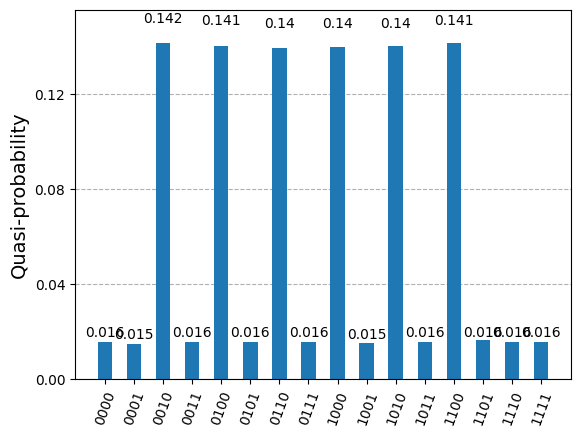

In [65]:
qc1.measure(qr, cr)

sampler = StatevectorSampler()
shots = 100000
 

job = sampler.run([qc1], shots=shots)
 
# Extract the result for the 0th pub (this example only has one pub)
result = job.result()[0]
counts = result.data.c.get_counts()

probs = {}
for key in counts.keys():
    probs[key] = counts[key]/shots

plot_histogram(probs)

Si aplicamos dos veces el operador de Grover, la probabilidad de éxito es:

$$\sin^{2}\left( 2\theta + \frac{\theta}{2} \right) \approx 0.9766$$

Lo que nos da una probabilidad de $0.09766$ para cada uno de los elementos marcados

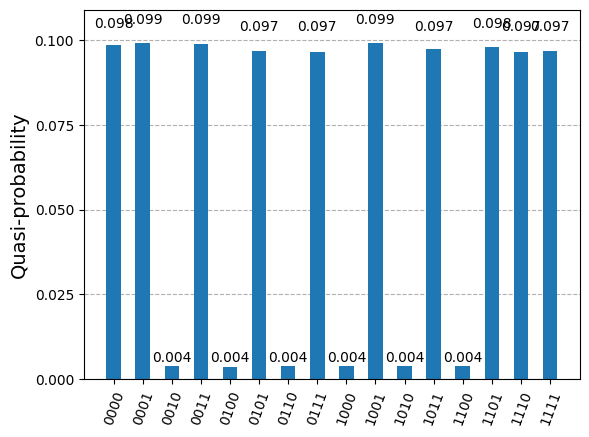

In [66]:
qc2.measure(qr, cr)

sampler = StatevectorSampler()
shots = 100000
 

job = sampler.run([qc2], shots=shots)
 
# Extract the result for the 0th pub (this example only has one pub)
result = job.result()[0]
counts = result.data.c.get_counts()


probs = {}
for key in counts.keys():
    probs[key] = counts[key]/shots

plot_histogram(probs)